In [1]:
feat = ['flow_duration',
 'Header_Length',
 'Protocol_Type',
 'Duration',
 'Rate',
 'Srate',
 'Drate',
 'rst_flag_number',
 'psh_flag_number',
 'cwr_flag_number',
 'ack_count',
 'syn_count',
 'fin_count',
 'urg_count',
 'rst_count',
 'HTTPS',
 'Telnet',
 'SMTP',
 'TCP',
 'UDP',
 'DHCP',
 'LLC',
 'Min',
 'AVG',
 'Std',
 'Tot_size',
 'IAT',
 'Radius',
 'Weight']


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from scipy.stats import shapiro
import time
from river import drift


In [3]:
df  = pd.read_csv(r'E:\Projects\Capstone\Final\Data\Recon_Brute.csv')

In [4]:
df.columns = df.columns.str.replace(' ', '_')

In [5]:
df.label.unique()

array(['Brute', 'Recon'], dtype=object)

In [6]:
df['label'] = df['label'].apply(lambda x: 0 if 'Recon' in str(x) else 1)

In [7]:
# Filter the dataset to include only the columns in the 'feat' list
X = df[feat]  # Assuming 'feat' is a list of column names
y = df['label']
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.1, test_size=0.9, shuffle=True, random_state=0, stratify=y
)

# Splitting x_test and Y_test further into smaller test and remaining subsets
X_test, x_test_remainig, y_test, y_test_remaining = train_test_split(
    X_test, y_test, train_size=0.2, test_size=0.8, shuffle=True, random_state=0, stratify=y_test
)



In [8]:
# Import the online learning metrics and algorithms from the River library
from river import metrics
from river import stream
from river import tree,neighbors,naive_bayes,ensemble,linear_model,forest
from river.drift.binary import DDM, EDDM,HDDM_A,HDDM_W
import logging

In [9]:
#With drift of 80

def adaptive_learning(model, X_train, y_train, X_test, y_test):
    metric = metrics.Accuracy() # Use accuracy as the metric
    i = 0 # count the number of evaluated data points
    t = [] # record the number of evaluated data points
    m = [] # record the real-time accuracy
    yt = [] # record all the true labels of the test set
    yp = [] # record all the predicted labels of the test set
    
    eddm = drift.binary.EDDM()
    
    # Learn the training set
    for xi1, yi1 in zip(X_train.values, y_train): 
        xi = dict(zip(X_train.columns, xi1))   
        model.learn_one(xi, yi1) 

    # Predict the test set and perform drift detection
    for x_val, y_val in zip(X_test.values, y_test):
        x = dict(zip(X_test.columns, x_val))
        y_pred = model.predict_one(x)  # Predict the test sample
        model.learn_one(x, y_val) # Learn the test sample
        metric.update(y_val, y_pred) # Update the real-time accuracy
        
        # Drift detection part
        val = 0
        
        if y_val != y_pred:
           val = 1 
           eddm.update(y_val)
        if eddm.drift_detected:
            print(f"Change detected at index {i}, input value: {y_val}")
            
           
        if eddm.warning_detected:
           print(f"Warning detected at index {i}")
        # Print samples every 80 iterations
        if i % 80 == 0:
            print(f"Sample {i}: True label: {y_val}, Predicted label: {y_pred}") 

        # Performance evaluation
        t.append(i)
        m.append(metric.get() * 100)
        yt.append(y_val)
        yp.append(y_pred)
        i += 1

    print("Accuracy: " + str(round(accuracy_score(yt, yp), 4) * 100) + "%")
    print("Precision: " + str(round(precision_score(yt, yp), 4) * 100) + "%")
    print("Recall: " + str(round(recall_score(yt, yp), 4) * 100) + "%")
    print("F1-score: " + str(round(f1_score(yt, yp), 4) * 100) + "%")

    return t, m

In [8]:
def setup_logger(log_file="adaptive_learning.log"):
    """
    Set up a logger that writes only to a file.
    """
    logger = logging.getLogger("AdaptiveLearningLogger")
    logger.setLevel(logging.INFO)

    # Check if handlers are already added to avoid duplicates
    if not logger.hasHandlers():
        # Create a file handler
        file_handler = logging.FileHandler(log_file)
        file_handler.setLevel(logging.INFO)

        # Create a logging format
        formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
        file_handler.setFormatter(formatter)

        # Add the handler to the logger
        logger.addHandler(file_handler)

    return logger

def adaptive_learning(model, X_train, y_train, X_test, y_test, logger=None):
    metric = metrics.Accuracy() # Use accuracy as the metric
    i = 0 # count the number of evaluated data points
    t = [] # record the number of evaluated data points
    m = [] # record the real-time accuracy
    yt = [] # record all the true labels of the test set
    yp = [] # record all the predicted labels of the test set
    
    eddm = drift.binary.EDDM()
    
    # Learn the training set
    for xi1, yi1 in zip(X_train.values, y_train): 
        xi = dict(zip(X_train.columns, xi1))   
        model.learn_one(xi, yi1) 

    # Predict the test set and perform drift detection
    for x_val, y_val in zip(X_test.values, y_test):
        x = dict(zip(X_test.columns, x_val))
        y_pred = model.predict_one(x)  # Predict the test sample
        model.learn_one(x, y_val) # Learn the test sample
        metric.update(y_val, y_pred) # Update the real-time accuracy
        
        # Drift detection part
        val = 0
        
        if y_val != y_pred:
           val = 1 
           eddm.update(y_val)
        if eddm.drift_detected:
            logger.info(f"Change detected at index {i}, input value: {y_val}")
        if eddm.warning_detected:
           logger.warning(f"Warning detected at index {i}")


        # Performance evaluation
        t.append(i)
        m.append(metric.get() * 100)
        yt.append(y_val)
        yp.append(y_pred)
        i += 1

    print("Accuracy: " + str(round(accuracy_score(yt, yp), 4) * 100) + "%")
    print("Precision: " + str(round(precision_score(yt, yp,average='weighted'), 4) * 100) + "%")
    print("Recall: " + str(round(recall_score(yt, yp,average='weighted'), 4) * 100) + "%")
    print("F1-score: " + str(round(f1_score(yt, yp,average='weighted'), 4) * 100) + "%")

    return t, m, logger


In [10]:
# Define a figure function that shows the real-time accuracy changes
def acc_fig(t, m, name):
    plt.rcParams.update({'font.size': 15})
    plt.figure(1,figsize=(10,6)) 
    sns.set_style("darkgrid")
    plt.clf() 
    #if m:  # Check if m is not empty
    plt.plot(t, m, '-b', label='Avg Accuracy: %.2f%%' % (m[-1]))

    #plt.plot(t,m,'-b',label='Avg Accuracy: %.2f%%'%(m[-1]))

    plt.legend(loc='best')
    plt.title(name+' on CICIoT 2023 dataset', fontsize=15)
    plt.xlabel('Number of samples')
    plt.ylabel('Accuracy (%)')

    plt.draw()

In [33]:
%%time
# Use the Adaptive Random Forest (ARF) model with ADWIN drift detector as a baseline model
name = "ARF model"
model = forest.ARFClassifier(n_models = 3) # Define the model
logger = setup_logger("drift_detection.log")
t, m, logger = adaptive_learning(model, X_train, y_train, X_test, y_test, logger=logger) # Learn the model on the dataset
acc_fig(t, m, name) # Draw the figure of how the real-time accuracy changes with the number of samples

NameError: name 'setup_logger' is not defined

Sample 0: True label: 1, Predicted label: 1
Sample 80: True label: 0, Predicted label: 0
Sample 160: True label: 1, Predicted label: 1
Sample 240: True label: 1, Predicted label: 1
Sample 320: True label: 0, Predicted label: 0
Sample 400: True label: 0, Predicted label: 0
Sample 480: True label: 0, Predicted label: 0
Sample 560: True label: 1, Predicted label: 1
Sample 640: True label: 1, Predicted label: 1
Sample 720: True label: 0, Predicted label: 0
Sample 800: True label: 1, Predicted label: 1
Sample 880: True label: 0, Predicted label: 0
Sample 960: True label: 1, Predicted label: 0
Sample 1040: True label: 1, Predicted label: 1
Sample 1120: True label: 1, Predicted label: 0
Warning detected at index 1142
Warning detected at index 1143
Warning detected at index 1144
Warning detected at index 1145
Warning detected at index 1146
Warning detected at index 1147
Warning detected at index 1148
Warning detected at index 1149
Warning detected at index 1150
Warning detected at index 1151
W

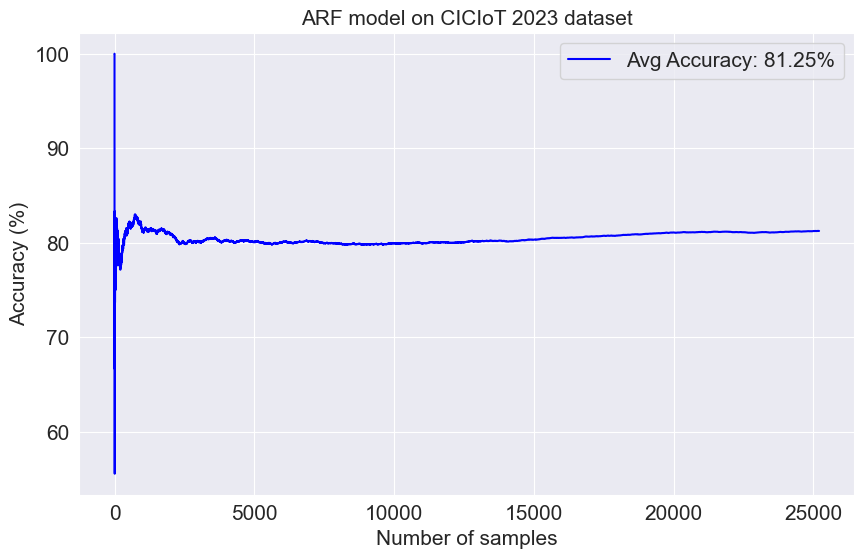

In [11]:
%%time
# Use the Adaptive Random Forest (ARF) model with ADWIN drift detector as a baseline model
name = "ARF model"
model = forest.ARFClassifier(n_models = 3,drift_detector=EDDM()) # Define the model
t, m = adaptive_learning(model, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m, name) # Draw the figure of how the real-time accuracy changes with the number of samples

Accuracy: 76.58%
Precision: 76.79%
Recall: 76.58%
F1-score: 76.53999999999999%
CPU times: total: 7.42 s
Wall time: 23.4 s


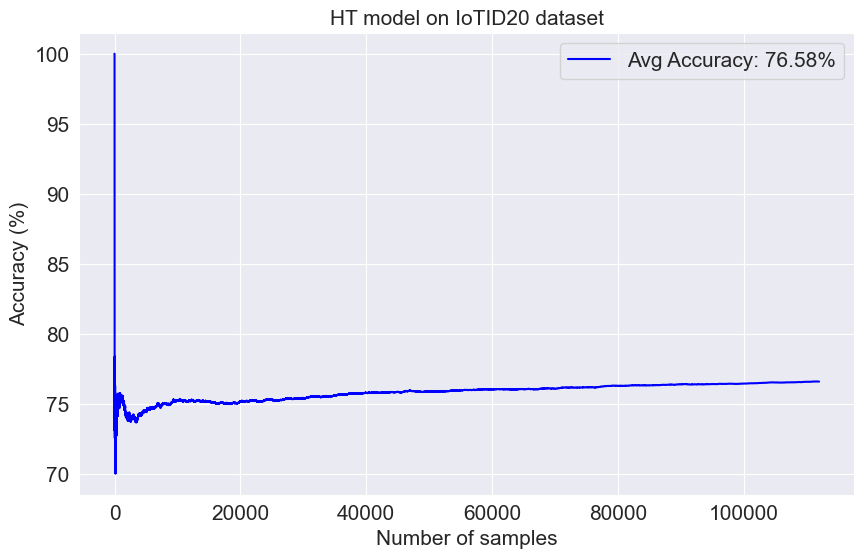

In [32]:
%%time
# Use the Hoeffding Tree (HT) model
name1 = "HT model"
model1 = tree.HoeffdingTreeClassifier()  # Define the model
logger1 = setup_logger("hoeffding_drift_detection.log")  # Set up logger for drift detection
t1, m1, logger1 = adaptive_learning(model1, X_train, y_train, X_test, y_test, logger=logger1)  # Learn the model on the dataset
acc_fig(t1, m1, name1)  # Draw the figure of how the real-time accuracy changes with the number of samples


Accuracy: 68.07%
Precision: 69.35%
Recall: 68.07%
F1-score: 67.54%
CPU times: total: 2min 3s
Wall time: 5min 19s


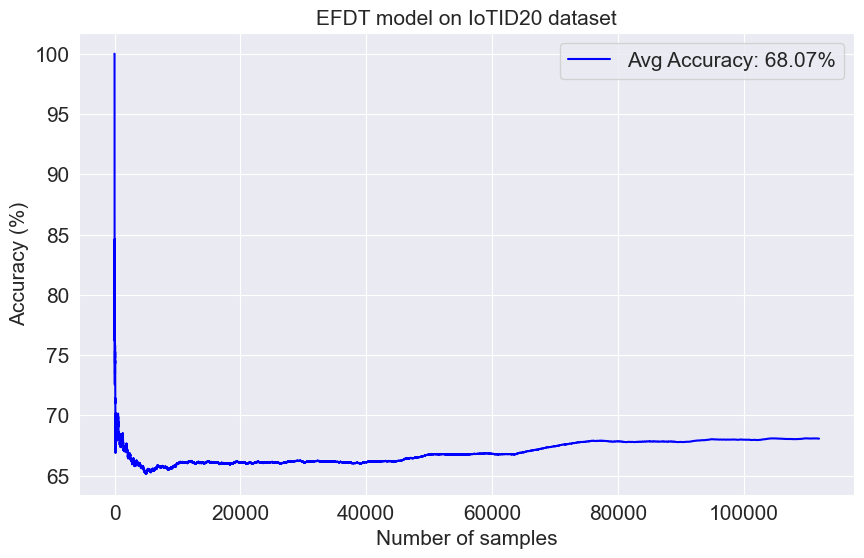

In [34]:
%%time
# Use the Extremely Fast Decision Tree (EFDT) model
name3 = "EFDT model"
model3 = tree.ExtremelyFastDecisionTreeClassifier()  # Define the model
logger3 = setup_logger("efdt_drift_detection.log")  # Set up logger for drift detection
t3, m3, logger3 = adaptive_learning(model3, X_train, y_train, X_test, y_test, logger=logger3)  # Learn the model on the dataset
acc_fig(t3, m3, name3)  # Draw the figure of how the real-time accuracy changes with the number of samples


Accuracy: 100.0%
Precision: 100.0%
Recall: 100.0%
F1-score: 100.0%
CPU times: total: 20 s
Wall time: 22.9 s


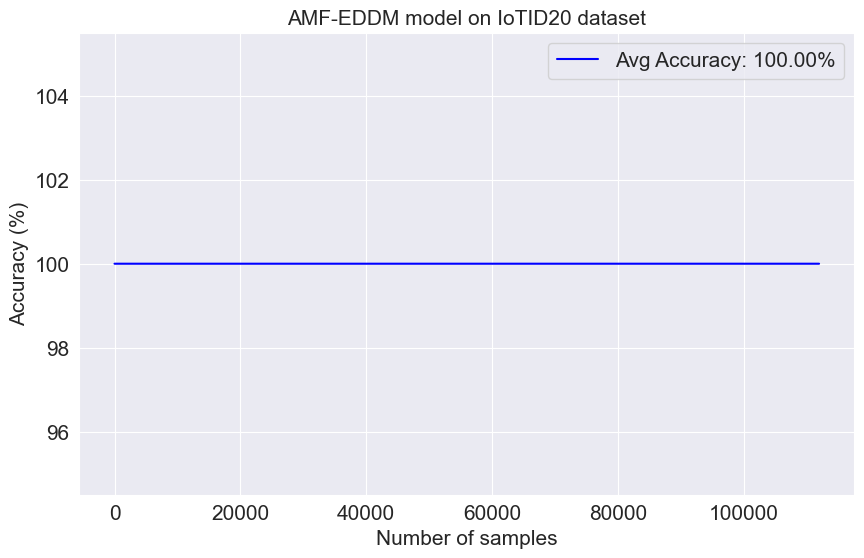

In [17]:
%%time
# Use the AMF-EDDM model
name4 = "AMF-EDDM model"
model4 = forest.AMFClassifier()  # Define the model
logger4 = setup_logger("amf_eddm_drift_detection.log")  # Set up logger for drift detection
t4, m4, logger4 = adaptive_learning(model4, X_train, y_train, X_test, y_test, logger=logger4)  # Learn the model on the dataset
acc_fig(t4, m4, name4)  # Draw the figure of how the real-time accuracy changes with the number of samples


Sample 0: True label: 1, Predicted label: 1
Sample 80: True label: 1, Predicted label: 1
Sample 160: True label: 0, Predicted label: 0
Sample 240: True label: 0, Predicted label: 0
Sample 320: True label: 1, Predicted label: 0
Sample 400: True label: 1, Predicted label: 1
Warning detected at index 424
Warning detected at index 425
Warning detected at index 426
Warning detected at index 427
Warning detected at index 428
Warning detected at index 429
Warning detected at index 430
Warning detected at index 431
Warning detected at index 432
Warning detected at index 433
Warning detected at index 434
Warning detected at index 435
Warning detected at index 436
Warning detected at index 437
Warning detected at index 438
Warning detected at index 439
Warning detected at index 440
Warning detected at index 441
Warning detected at index 442
Warning detected at index 443
Warning detected at index 444
Warning detected at index 445
Warning detected at index 446
Warning detected at index 447
Warning

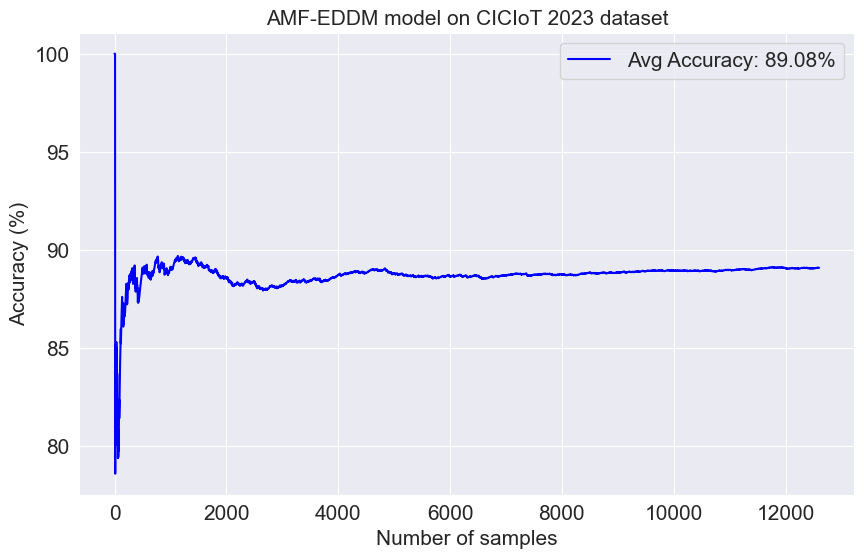

In [28]:
%%time
# Use the AMF-EDDM model
name4 = "AMF-EDDM model"
model4 = forest.AMFClassifier()  # Define the model
t4, m4 = adaptive_learning(model4, X_train, y_train, X_test, y_test)  # Learn the model on the dataset
acc_fig(t4, m4, name4)  # Draw the figure of how the real-time accuracy changes with the number of samples


In [1]:
%%time
# Use the SRP Model
name5 = "SRP Model"
model5 = ensemble.SRPClassifier()  # Define the model
logger5 = setup_logger("srp_drift_detection.log")  # Set up logger for drift detection
t5, m5, logger5 = adaptive_learning(model5, X_train, y_train, X_test, y_test, logger=logger5)  # Learn the model on the dataset
acc_fig(t5, m5, name5)  # Draw the figure of how the real-time accuracy changes with the number of samples


NameError: name 'ensemble' is not defined

Sample 0: True label: 1, Predicted label: 1
Sample 80: True label: 0, Predicted label: 1
Sample 160: True label: 1, Predicted label: 1
Sample 240: True label: 1, Predicted label: 1
Sample 320: True label: 0, Predicted label: 0
Sample 400: True label: 0, Predicted label: 0
Change detected at index 449, input value: 1
Sample 480: True label: 0, Predicted label: 0
Sample 560: True label: 1, Predicted label: 1
Sample 640: True label: 1, Predicted label: 1
Sample 720: True label: 0, Predicted label: 0
Sample 800: True label: 1, Predicted label: 1
Sample 880: True label: 0, Predicted label: 0
Sample 960: True label: 1, Predicted label: 1
Change detected at index 1031, input value: 1
Sample 1040: True label: 1, Predicted label: 1
Sample 1120: True label: 1, Predicted label: 1
Sample 1200: True label: 1, Predicted label: 1
Sample 1280: True label: 1, Predicted label: 0
Sample 1360: True label: 1, Predicted label: 1
Sample 1440: True label: 1, Predicted label: 1
Sample 1520: True label: 1, Pred

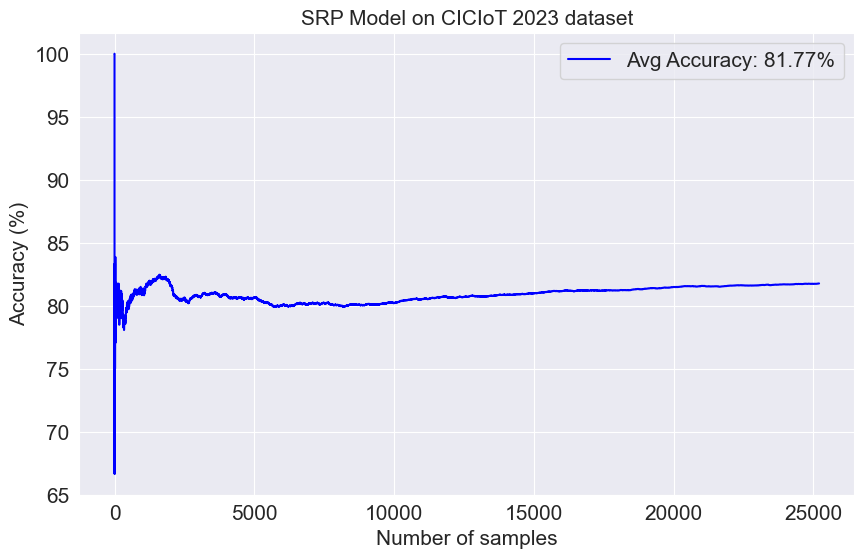

In [12]:
%%time
# Use the Hoeffding Tree (HT) model 
name5 = "SRP Model"
model5 = ensemble.SRPClassifier() # Define the model
t, m5 = adaptive_learning(model5, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m5, name5) # Draw the figure of how the real-time accuracy changes with the number of samples

Accuracy: 87.85%
Precision: 88.17%
Recall: 87.85%
F1-score: 87.82%
Time in seconds: 2691.585282087326


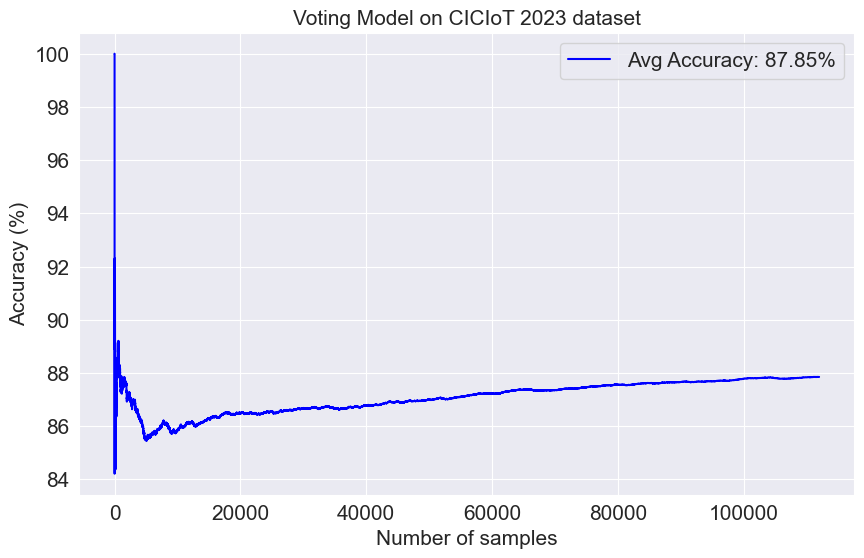

In [13]:
start = time.time()

# Use the Voting Classifier model
name10 = "Voting Model"
model10 = ensemble.VotingClassifier(
    [
        forest.AMFClassifier(),
        forest.ARFClassifier(),
        tree.ExtremelyFastDecisionTreeClassifier(),
        tree.HoeffdingAdaptiveTreeClassifier(),
    ]
)

# Set up logger for drift detection
logger10 = setup_logger("voting_model_drift_detection.log")

# Learn the model on the dataset
t10, m10, logger10 = adaptive_learning(model10, X_train, y_train, X_test, y_test, logger=logger10)

# Draw the figure of how the real-time accuracy changes with the number of samples
acc_fig(t10, m10, name10)

end = time.time()
print("Time in seconds:", (end - start))


In [25]:
from river import preprocessing

CPU times: total: 0 ns
Wall time: 0 ns
Sample 0: True label: 1, Predicted label: 1
Sample 80: True label: 1, Predicted label: 1
Sample 160: True label: 0, Predicted label: 0
Sample 240: True label: 0, Predicted label: 0
Sample 320: True label: 1, Predicted label: 0
Warning detected at index 362
Warning detected at index 363
Warning detected at index 364
Warning detected at index 365
Warning detected at index 366
Warning detected at index 367
Warning detected at index 368
Warning detected at index 369
Warning detected at index 370
Warning detected at index 371
Warning detected at index 372
Warning detected at index 373
Warning detected at index 374
Warning detected at index 375
Warning detected at index 376
Warning detected at index 377
Warning detected at index 378
Warning detected at index 379
Warning detected at index 380
Warning detected at index 381
Warning detected at index 382
Warning detected at index 383
Warning detected at index 384
Warning detected at index 385
Warning detect

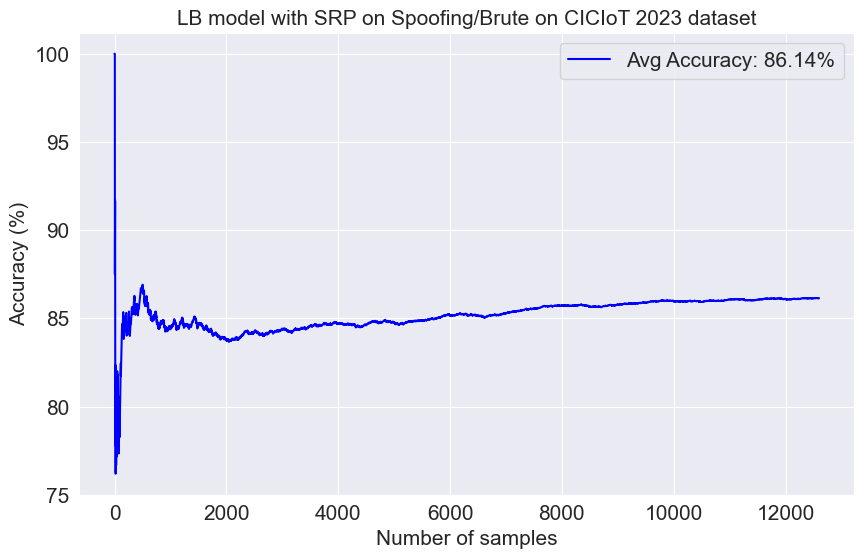

In [27]:
%time
# Use the Hoeffding Tree (HT) model 
name6 = "LB model with SRP on Spoofing/Brute"
model6 = ensemble.LeveragingBaggingClassifier(
    
    model=(
        preprocessing.StandardScaler() |
        ensemble.SRPClassifier()
    ),
    n_models=3,
    seed=42
)

# Define the model
t, m6 = adaptive_learning(model6, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m6, name6) # Draw the figure of how the real-time accuracy changes with the number of samples

In [ ]:
%%time
# Use the Leveraging Bagging (LB) model
name6 = "LB model"
model6 = ensemble.LeveragingBaggingClassifier(
    model=(
        preprocessing.StandardScaler() |  # Preprocessing with standard scaling
        tree.ExtremelyFastDecisionTreeClassifier()  # Base model
    ),
    n_models=3,  # Number of models in the ensemble
    seed=42  # Random seed for reproducibility
)

# Set up logger for drift detection
logger6 = setup_logger("lb_model_drift_detection.log")

# Learn the model on the dataset
t6, m6, logger6 = adaptive_learning(model6, X_train, y_train, X_test, y_test, logger=logger6)

# Draw the figure of how the real-time accuracy changes with the number of samples
acc_fig(t6, m6, name6)


In [ ]:
%%time
# Use the Leveraging Bagging (LB) model
name6 = "LB model"
model6 = ensemble.LeveragingBaggingClassifier(
    model=(
        preprocessing.StandardScaler() |  # Preprocessing with standard scaling
        tree.HoeffdingAdaptiveTreeClassifier()
    ),
    n_models=3,  # Number of models in the ensemble
    seed=42  # Random seed for reproducibility
)

# Set up logger for drift detection
logger6 = setup_logger("lb_model_drift_detection.log")

# Learn the model on the dataset
t6, m6, logger6 = adaptive_learning(model6, X_train, y_train, X_test, y_test, logger=logger6)

# Draw the figure of how the real-time accuracy changes with the number of samples
acc_fig(t6, m6, name6)


In [ ]:
%%time
# Use the Leveraging Bagging (LB) model
name6 = "LB model"
model6 = ensemble.LeveragingBaggingClassifier(
    model=(
        preprocessing.StandardScaler() |  # Preprocessing with standard scaling
        tree.HoeffdingTreeClassifier()
    ),
    n_models=3,  # Number of models in the ensemble
    seed=42  # Random seed for reproducibility
)

# Set up logger for drift detection
logger6 = setup_logger("lb_model_drift_detection.log")

# Learn the model on the dataset
t6, m6, logger6 = adaptive_learning(model6, X_train, y_train, X_test, y_test, logger=logger6)

# Draw the figure of how the real-time accuracy changes with the number of samples
acc_fig(t6, m6, name6)


In [ ]:
%%time
# Use the Leveraging Bagging (LB) model
name6 = "LB model"
model6 = ensemble.LeveragingBaggingClassifier(
    model=(
        preprocessing.StandardScaler() |  # Preprocessing with standard scaling
        tree.ARFClassifier()
    ),
    n_models=3,  # Number of models in the ensemble
    seed=42  # Random seed for reproducibility
)

# Set up logger for drift detection
logger6 = setup_logger("lb_model_drift_detection.log")

# Learn the model on the dataset
t6, m6, logger6 = adaptive_learning(model6, X_train, y_train, X_test, y_test, logger=logger6)

# Draw the figure of how the real-time accuracy changes with the number of samples
acc_fig(t6, m6, name6)


In [ ]:
%%time
# Use the Leveraging Bagging (LB) model
name6 = "LB model"
model6 = ensemble.LeveragingBaggingClassifier(
    model=(
        preprocessing.StandardScaler() |  # Preprocessing with standard scaling
        tree.AMFClassifier()
    ),
    n_models=3,  # Number of models in the ensemble
    seed=42  # Random seed for reproducibility
)

# Set up logger for drift detection
logger6 = setup_logger("lb_model_drift_detection.log")

# Learn the model on the dataset
t6, m6, logger6 = adaptive_learning(model6, X_train, y_train, X_test, y_test, logger=logger6)

# Draw the figure of how the real-time accuracy changes with the number of samples
acc_fig(t6, m6, name6)


In [ ]:
%%time
# Use the Leveraging Bagging (LB) model
name6 = "LB model"
model6 = ensemble.LeveragingBaggingClassifier(
    model=(
        preprocessing.StandardScaler() |  # Preprocessing with standard scaling
        tree.SRPClassifier()
    ),
    n_models=3,  # Number of models in the ensemble
    seed=42  # Random seed for reproducibility
)

# Set up logger for drift detection
logger6 = setup_logger("lb_model_drift_detection.log")

# Learn the model on the dataset
t6, m6, logger6 = adaptive_learning(model6, X_train, y_train, X_test, y_test, logger=logger6)

# Draw the figure of how the real-time accuracy changes with the number of samples
acc_fig(t6, m6, name6)


In [ ]:
%%time
# Use the ADWIN Bagging (Adwinbagging) model
name7 = "Adwinbagging model"
model7 = ensemble.ADWINBaggingClassifier(
    model=(
        preprocessing.StandardScaler() |  # Preprocessing with standard scaling
        tree.HoeffdingAdaptiveTreeClassifier()  # Base model
    ),
    n_models=3,  # Number of models in the ensemble
    seed=42  # Random seed for reproducibility
)

# Set up logger for drift detection
logger7 = setup_logger("adwinbagging_model_drift_detection.log")

# Learn the model on the dataset
t7, m7, logger7 = adaptive_learning(model7, X_train, y_train, X_test, y_test, logger=logger7)

# Draw the figure of how the real-time accuracy changes with the number of samples
acc_fig(t7, m7, name7)


In [ ]:
%%time
# Use the ADWIN Bagging (Adwinbagging) model
name7 = "Adwinbagging model"
model7 = ensemble.ADWINBaggingClassifier(
    model=(
        preprocessing.StandardScaler() |  # Preprocessing with standard scaling
        tree.HoeffdingTreeClassifier()  # Base model
    ),
    n_models=3,  # Number of models in the ensemble
    seed=42  # Random seed for reproducibility
)

# Set up logger for drift detection
logger7 = setup_logger("adwinbagging_model_drift_detection.log")

# Learn the model on the dataset
t7, m7, logger7 = adaptive_learning(model7, X_train, y_train, X_test, y_test, logger=logger7)

# Draw the figure of how the real-time accuracy changes with the number of samples
acc_fig(t7, m7, name7)


In [ ]:
%%time
# Use the ADWIN Bagging (Adwinbagging) model
name7 = "Adwinbagging model"
model7 = ensemble.ADWINBaggingClassifier(
    model=(
        preprocessing.StandardScaler() |  # Preprocessing with standard scaling
        tree.ARFClassifier()  # Base model
    ),
    n_models=3,  # Number of models in the ensemble
    seed=42  # Random seed for reproducibility
)

# Set up logger for drift detection
logger7 = setup_logger("adwinbagging_model_drift_detection.log")

# Learn the model on the dataset
t7, m7, logger7 = adaptive_learning(model7, X_train, y_train, X_test, y_test, logger=logger7)

# Draw the figure of how the real-time accuracy changes with the number of samples
acc_fig(t7, m7, name7)


In [ ]:
%%time
# Use the ADWIN Bagging (Adwinbagging) model
name7 = "Adwinbagging model"
model7 = ensemble.ADWINBaggingClassifier(
    model=(
        preprocessing.StandardScaler() |  # Preprocessing with standard scaling
        tree.AMFClassifier()  # Base model
    ),
    n_models=3,  # Number of models in the ensemble
    seed=42  # Random seed for reproducibility
)

# Set up logger for drift detection
logger7 = setup_logger("adwinbagging_model_drift_detection.log")

# Learn the model on the dataset
t7, m7, logger7 = adaptive_learning(model7, X_train, y_train, X_test, y_test, logger=logger7)

# Draw the figure of how the real-time accuracy changes with the number of samples
acc_fig(t7, m7, name7)


In [ ]:
%%time
# Use the ADWIN Bagging (Adwinbagging) model
name7 = "Adwinbagging model"
model7 = ensemble.ADWINBaggingClassifier(
    model=(
        preprocessing.StandardScaler() |  # Preprocessing with standard scaling
        tree.SRPClassifier()  # Base model
    ),
    n_models=3,  # Number of models in the ensemble
    seed=42  # Random seed for reproducibility
)

# Set up logger for drift detection
logger7 = setup_logger("adwinbagging_model_drift_detection.log")

# Learn the model on the dataset
t7, m7, logger7 = adaptive_learning(model7, X_train, y_train, X_test, y_test, logger=logger7)

# Draw the figure of how the real-time accuracy changes with the number of samples
acc_fig(t7, m7, name7)


In [ ]:
%%time
# Use the ADWIN Bagging (Adwinbagging) model
name8 = "AdaBoost model"
model8 = ensemble.AdaBoostClassifier(
    model=(
        preprocessing.StandardScaler() |  # Preprocessing with standard scaling
        tree.SRPClassifier()  # Base model
    ),
    n_models=3,  # Number of models in the ensemble
    seed=42  # Random seed for reproducibility
)

# Set up logger for drift detection
logger9 = setup_logger("adwinbagging_model_drift_detection.log")

# Learn the model on the dataset
t8, m8, logger8 = adaptive_learning(model8, X_train, y_train, X_test, y_test, logger=logger8)

# Draw the figure of how the real-time accuracy changes with the number of samples
acc_fig(t8, m8, name8)
